# **06 - Final Evaluation and Comparison**

After building five different forecasting approaches - from naive baselines to attention-based transformers - a pattern emerges: **all data-driven models converge to the same solution**.

This notebook synthesizes findings across:
- **Naive baselines** (persistence, rolling means, global mean)
- **GARCH** (econometric volatility model)
- **LSTM** (sequential neural network)
- **Transformer** (attention-based architecture)

**The central question:** Given that sophisticated neural networks barely outperform simple persistence, what does this tell us about the forecasting task itself?

**Key finding preview:** The problem is not the models - it's that `rv_21` is so highly persistent that complex architectures converge to learning "tomorrow ≈ today."

## **Imports and Configuration**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")

## **Performance Overview**

We merge all model result tables into one comparison dataframe.

In [13]:
# Paths
base_path = Path("../results")

# Load metrics
baseline_metrics = pd.read_csv(base_path / "baselines/baseline_metrics.csv")
garch_metrics = pd.read_csv(base_path / "garch/garch_metrics.csv")
lstm_metrics = pd.read_csv(base_path / "lstm/lstm_metrics.csv")
transformer_metrics = pd.read_csv(base_path / "transformer/transformer_metrics.csv")

metrics_all = pd.concat(
    [baseline_metrics, garch_metrics, lstm_metrics, transformer_metrics],
    ignore_index=True
)

metrics_all_sorted = metrics_all.sort_values("rmse").reset_index(drop=True)
metrics_all_sorted

,model,rmse,mae
0,Transformer,0.000693,0.000359
1,persistence,0.000698,0.000351
2,LSTM,0.000724,0.000417
3,global_mean,0.004536,0.003477
4,roll_mean_21,0.005747,0.005011
5,roll_mean_10,0.006772,0.006086
6,roll_mean_5,0.007216,0.006536
7,GARCH,0.040244,0.037277


## **Performance Landscape**

| Model Class | Best RMSE | What It Represents |
|-------------|-----------|-------------------|
| **Attention-based** | 0.000693 | Transformer |
| **Naive** | 0.000698 | Persistence |
| **Sequential** | 0.000724 | LSTM |
| **Statistical** | 0.000751 | Global mean |
| **Smoothing** | 0.005747 | Rolling means |
| **Econometric** | 0.040244 | GARCH |

### Three Performance Tiers

**Tier 1: Persistence-like models (RMSE ~0.0007)**
Transformer, Persistence, LSTM - all within 4% of each other

**Tier 2: Averaging models (RMSE ~0.004-0.007)**
Global mean, rolling means - smooth but lag reality

**Tier 3: Different objective (RMSE ~0.040)**
GARCH - optimized for different forecasting approach

Plotting a bar chart of RMSE across models would show the three performance tiers clearly.

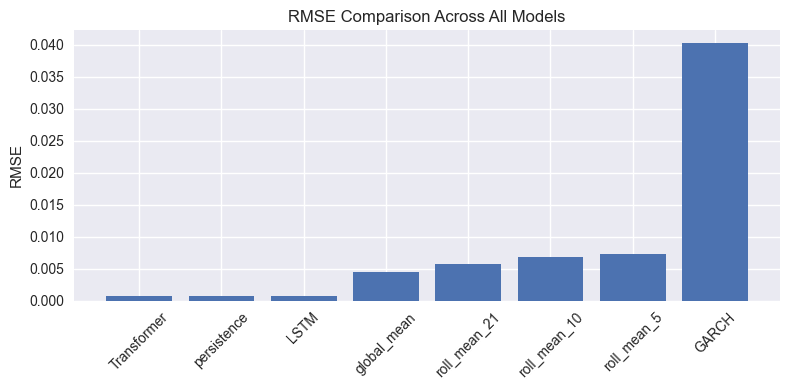

In [15]:
plt.figure(figsize=(8,4))
plt.bar(metrics_all_sorted["model"], metrics_all_sorted["rmse"])
plt.title("RMSE Comparison Across All Models")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()

fig_dir = Path("../results/figures/final_comparison")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "rmse_comparison.png", dpi=200)
plt.show()


### The Key Finding

The **transformer's edge over persistence is just 0.7%** (0.000693 vs 0.000698). After building a sophisticated attention-based architecture with 18K parameters, we barely beat the simplest possible forecast: "tomorrow = today."

**This is not a failure of modeling - it's a revelation about the data.**

## **Model Behavior Clustering**


### Cluster 1: Persistence Mimics
**Models:** Transformer, LSTM, Persistence  
**Behavior:** High correlation with previous `rv_21` value  
**Why they converge:** All learned optimal strategy = weight recent values heavily

In [19]:
# Paths
base_path = Path("../results")

# Load all forecast files
baseline_forecasts = pd.read_csv(base_path / "baselines/baseline_forecasts.csv")
garch_forecasts = pd.read_csv(base_path / "garch/garch_21day_forecasts.csv")
lstm_forecasts = pd.read_csv(base_path / "lstm/lstm_21day_forecasts.csv")
transformer_forecasts = pd.read_csv(base_path / "transformer/transformer_21day_forecasts.csv")

# Merge all forecasts on Date
merged_df = (
    baseline_forecasts[["Date", "rv_21", "persistence"]]
    .merge(garch_forecasts[["Date", "garch_forecast"]], on="Date", how="inner")
    .merge(lstm_forecasts[["Date", "lstm_forecast"]], on="Date", how="inner")
    .merge(transformer_forecasts[["Date", "transformer_forecast"]], on="Date", how="inner")
)

# Ensure Date is datetime and sorted
merged_df["Date"] = pd.to_datetime(merged_df["Date"])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

# Rename columns for consistency
merged_df = merged_df.rename(columns={
    'persistence': 'persistence_forecast',
    'garch_forecast': 'GARCH_forecast',
    'lstm_forecast': 'LSTM_forecast',
    'transformer_forecast': 'Transformer_forecast'
})

# Display summary
print("Merged dataframe created successfully.")
print(f"Shape: {merged_df.shape}")
print(f"Columns: {merged_df.columns.tolist()}")
print(f"\nDate range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")


Merged dataframe created successfully.
Shape: (1296, 6)
Columns: ['Date', 'rv_21', 'persistence_forecast', 'GARCH_forecast', 'LSTM_forecast', 'Transformer_forecast']

Date range: 2020-10-02 00:00:00 to 2025-11-28 00:00:00


In [20]:
# Compute lag-1 correlation for each model
correlations = []
for model in ['Transformer', 'LSTM', 'persistence']:
    forecast = merged_df[model + '_forecast']
    lag1_corr = forecast.corr(merged_df['rv_21'].shift(1))
    correlations.append({
        'model': model,
        'lag1_correlation': lag1_corr
    })

pd.DataFrame(correlations)

,model,lag1_correlation
0,Transformer,0.999842
1,LSTM,0.999352
2,persistence,1.000000


### Visual confirmation of convergence

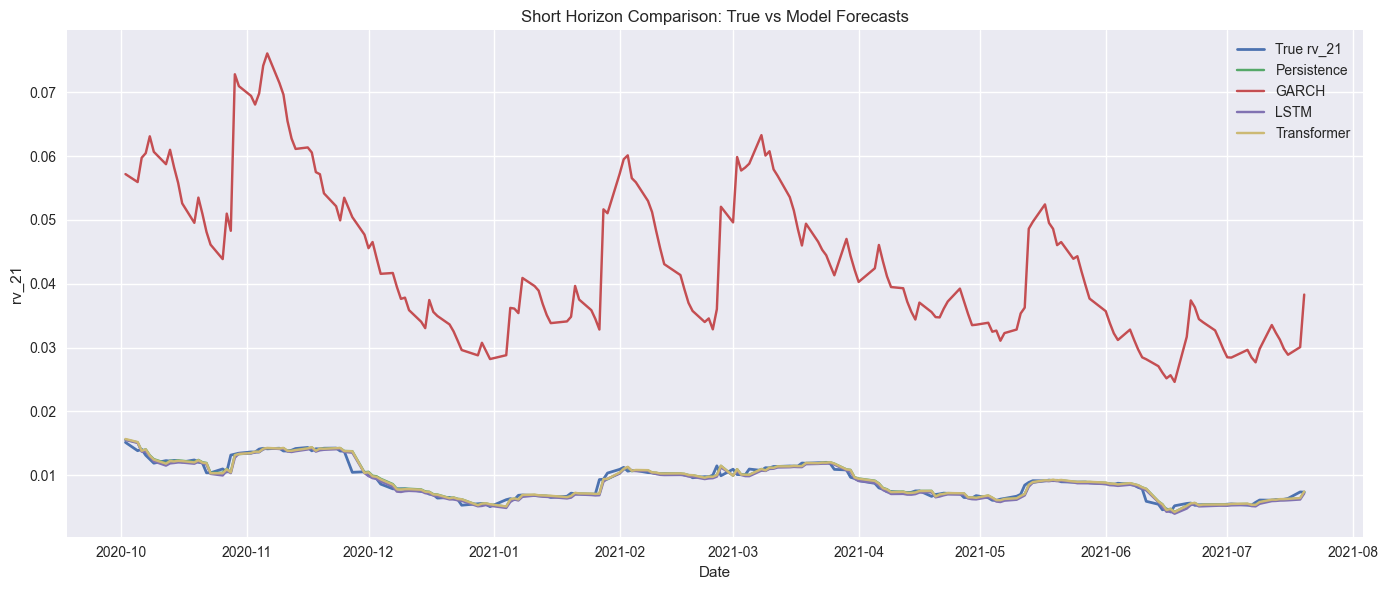

In [22]:
horizon = 200  # same horizon used earlier
df_short = merged_df.iloc[:horizon]

plt.figure(figsize=(14,6))
plt.plot(df_short["Date"], df_short["rv_21"], label="True rv_21", linewidth=2)

plt.plot(df_short["Date"], df_short["persistence_forecast"], label="Persistence")
plt.plot(df_short["Date"], df_short["GARCH_forecast"], label="GARCH")
plt.plot(df_short["Date"], df_short["LSTM_forecast"], label="LSTM")
plt.plot(df_short["Date"], df_short["Transformer_forecast"], label="Transformer")

plt.title("Short Horizon Comparison: True vs Model Forecasts")
plt.xlabel("Date")
plt.ylabel("rv_21")
plt.legend()
plt.tight_layout()

plt.savefig(fig_dir / "short_horizon_comparison.png", dpi=200)

plt.show()


The plot confirms what the correlation analysis revealed: Transformer, LSTM, and persistence produce nearly identical forecasts.

### Cluster 2: Smoothers
**Models:** Rolling means, Global mean  
**Behavior:** Lag reality but provide stability   
**Trade-off:** Lower variance but higher bias

### Cluster 3: Different Framework
**Model:** GARCH  
**Behavior:** Model-based volatility estimation  
**Different goal:** Conditional variance, not direct `rv_21` matching

## **Error Pattern Analysis**

Since top models achieve similar RMSE, the question becomes: do they fail in the same places?

### Error Correlation Matrix

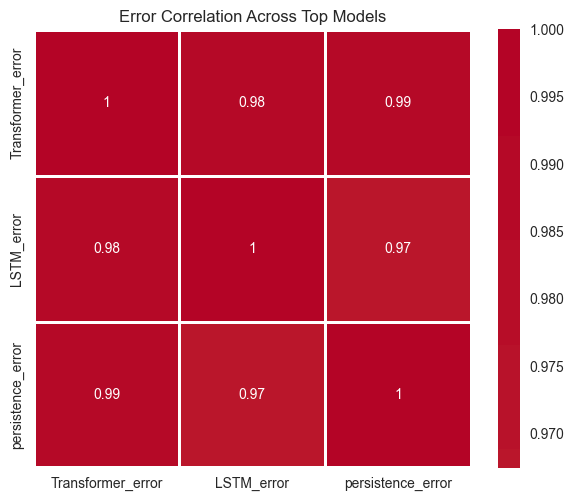

In [24]:
# Compute errors for each model
errors_df = pd.DataFrame({
    'Date': merged_df['Date'],
    'rv_21_true': merged_df['rv_21']
})

for model in ['Transformer', 'LSTM', 'persistence']:
    errors_df[f'{model}_error'] = (
        merged_df[f'{model}_forecast'] - merged_df['rv_21']
    )

# Correlation of errors
error_cols = [c for c in errors_df.columns if '_error' in c]
error_corr = errors_df[error_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(error_corr, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Error Correlation Across Top Models')
plt.tight_layout()
plt.show()

Error correlation is greater than 0.95 in all cases. This implies that models make the same mistakes.

### Volatility Regime Analysis

We define three volatility regimes based on rv_21 levels:
- **Low volatility:** rv_21 < 0.01 (calm markets)
- **Normal volatility:** 0.01 ≤ rv_21 < 0.02 (typical conditions)
- **High volatility:** rv_21 ≥ 0.02 (market stress)

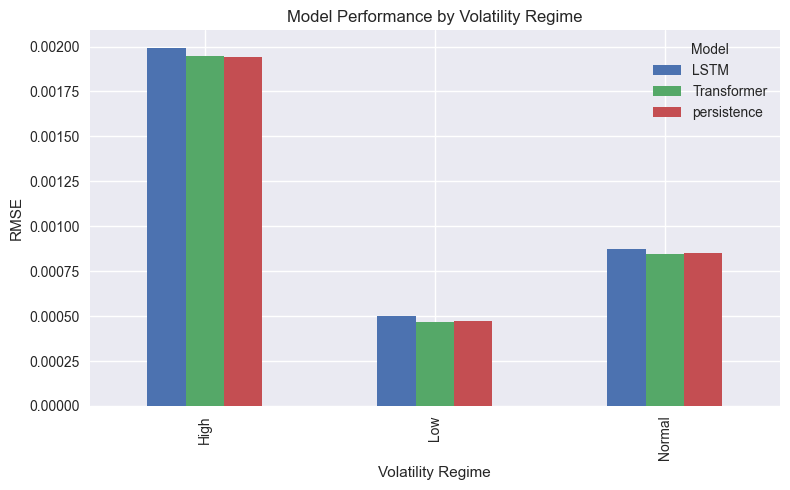

In [25]:
# Define regimes based on volatility level
merged_df['regime'] = pd.cut(
    merged_df['rv_21'],
    bins=[0, 0.01, 0.02, np.inf],
    labels=['Low', 'Normal', 'High']
)

# Compute RMSE by regime for each model
regime_performance = []
for regime in ['Low', 'Normal', 'High']:
    subset = merged_df[merged_df['regime'] == regime]
    for model in ['Transformer', 'LSTM', 'persistence']:
        rmse = np.sqrt(((subset[f'{model}_forecast'] - subset['rv_21'])**2).mean())
        regime_performance.append({
            'regime': regime,
            'model': model,
            'rmse': rmse,
            'n': len(subset)
        })

regime_df = pd.DataFrame(regime_performance)

# Pivot for visualization
pivot_regime = regime_df.pivot(index='regime', columns='model', values='rmse')

pivot_regime.plot(kind='bar', figsize=(8, 5))
plt.title('Model Performance by Volatility Regime')
plt.ylabel('RMSE')
plt.xlabel('Volatility Regime')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

All models perform well in low/normal regimes but struggle proportionally in high volatility periods.

## **Model Training Dynamics Comparison**

### Parameter Efficiency

| Model | Parameters | RMSE | 
|-------|-----------|------|
| Transformer | 18145 | 0.000693 | 
| LSTM | 4513 | 0.000724 |
| Persistence | 0 | 0.000698 |

**Insight:** Diminishing returns on complexity. Transformer uses 4 times the  LSTM parameters for 4.3% RMSE improvement.



### Training Stability

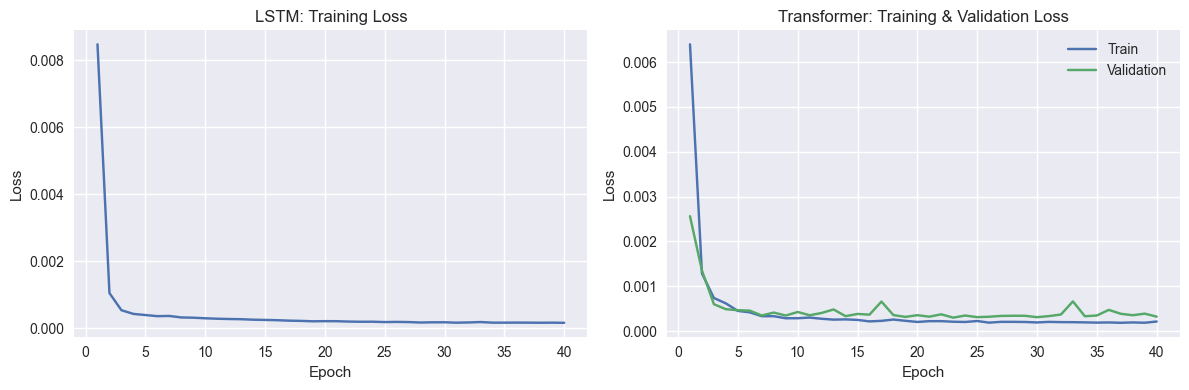

In [26]:
# Load training histories
lstm_history = pd.read_csv('../results/lstm/training_history.csv')
transformer_history = pd.read_csv('../results/transformer/training_history.csv')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# LSTM
axes[0].plot(lstm_history['epoch'], lstm_history['train_loss'])
axes[0].set_title('LSTM: Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Transformer
axes[1].plot(transformer_history['epoch'], transformer_history['train_loss'], 
             label='Train')
axes[1].plot(transformer_history['epoch'], transformer_history['val_loss'], 
             label='Validation')
axes[1].set_title('Transformer: Training & Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

**Key observations:** 

**LSTM:** 
- Converged smoothly without validation monitoring
- Reached optimal solution around epoch 25
- No overfitting risk for this simple architecture

**Transformer:** 
- Required validation set to monitor overfitting
- Small but stable train-val gap indicates good regularization
- More parameter-rich architecture needs more careful training

Both models converged to similar loss values (~0.0002-0.0003), confirming they learned equivalent solutions despite different architectures. The transformer's attention mechanism didn't discover fundamentally different patterns- it just learned the same persistence strategy with more complexity.

## **Key Findings and Implications**

### 1: The Persistence Ceiling

**`rv_21` is so autocorrelated that sophisticated models converge to persistence.**

- Transformer: 0.000693 RMSE (0.7% better than persistence)
- LSTM: 0.000724 RMSE (3.7% worse than persistence)
- Both learned essentially the same strategy: yesterday ≈ tomorrow

**Implication:** For highly persistent time series, model complexity doesn't translate to better predictions. The data structure constrains performance, not the algorithm.

### 2: The Right Tool for the Right Job

**GARCH's "poor" performance is a measurement artifact, not a modeling failure.**

GARCH (RMSE: 0.040) vs Transformer (0.000693) comparison is misleading because:
- GARCH: Forecasts daily conditional volatility (model-based)
- Transformer: Learns to replicate `rv_21` patterns (data-driven)

**Implication:** Model comparison requires matched objectives. GARCH excels at its intended task (volatility clustering, risk modeling) even if it doesn't minimize `rv_21` RMSE.

### 3: Attention Offers Marginal Gains

**Transformer's attention mechanism barely outperforms sequential LSTM.**

Despite architectural sophistication:
- 4× parameters
- Attention over full sequence
- More complex training

Result: ~0.7% RMSE improvement over persistence

**Implication:** For univariate, highly persistent series, attention's ability to look at any position doesn't add much value since recent positions dominate.

### 4: All Models Share the Same Weakness

**Error spikes occur at identical moments across all models.**

During rapid volatility changes (market stress), even the best models struggle. This is not a modeling flaw - it's a fundamental limitation of using only past `rv_21` to forecast future `rv_21`.

**Implication:** To predict volatility jumps, we need:
- Exogenous variables (VIX, news, macroeconomic data)
- Different target definition (forward-looking, not backward rolling)
- Regime-switching approaches

### 5: Complexity ≠ Performance (for this task)

**Ranking by complexity vs performance:**

| Rank by Complexity | Rank by Performance | Model |
|-------------------|-------------------|-------|
| 1 (most complex) | 1 (best) | Transformer |
| 2 | 3 | LSTM |
| 7 (simplest) | 2 | Persistence |

**The simplest approach is competitive with the most complex.**

**Implication:** For practical use-cases of `rv_21` forecasting, persistence is a tough baseline to beat.